# Project Work 2 - IRM24
## Natalia Trudova, Raphael Albert & J√ºrgen Aumayr
Die Stadt Graz ist seit vielen Jahren mit erheblichen Problemen durch Feinstaubbelastung (PM10) und schlechter Luftqualit√§t konfrontiert. Aufgrund ihrer geografischen Lage und klimatischen Besonderheiten kommt es regelm√§√üig zu √úberschreitungen der EU-Grenzwerte f√ºr Luftschadstoffe. Um diese Herausforderungen zu adressieren und fundierte politische Entscheidungen zu erm√∂glichen, werden in Graz systematisch Luftqualit√§ts- und Wetterdaten erhoben und analysiert.
Dieses Jupyter Notebook bietet eine vollst√§ndige Analyse- und Modellierungspipeline f√ºr die Vorhersage der Tagesmittelwerte von PM10 und NO‚ÇÇ an Messstationen in Graz auf Basis von Messdaten aus den Jahren 2015 bis 2020. Die Daten umfassen neben den Zielgr√∂√üen verschiedene meteorologische Pr√§diktoren (z.B. Temperatur, Luftfeuchtigkeit, Wind, Niederschlag) sowie saisonale und wochentagsbezogene Einfl√ºsse.

Im Fokus stehen folgende Fragestellungen:

* Wie verteilen sich die einzelnen Pr√§diktoren und Zielgr√∂√üen √ºber die Zeit? Gibt es saisonale oder wochentagsbezogene Muster?
* Welche Zusammenh√§nge bestehen zwischen meteorologischen Einflussgr√∂√üen und den Schadstoffkonzentrationen?
* Wie gut lassen sich PM10 und NO‚ÇÇ mit Hilfe neuronaler Netze vorhersagen?
* Welche Bedeutung haben spezielle Wetterlagen (z.B. Inversionen) f√ºr die Luftqualit√§t in Graz?

Das Notebook umfasst:

* Datenexploration und Visualisierung: √úberblick √ºber Wertebereiche, Verteilungen, Saisonalit√§t und fehlende Werte.
* Feature Engineering: Ableitung zus√§tzlicher erkl√§render Variablen (z.B. Frost, Inversionsindikator, Lag-Features).
* Modellierung: Training separater neuronaler Netze f√ºr PM10 und NO‚ÇÇ auf Basis der Jahre 2015‚Äì2019.
* Validierung und Prognose: Bewertung der Modellg√ºte und Vorhersage f√ºr das Jahr 2020.

## 1. Daten einlesen

In [1]:
# Grundlegende Datenverarbeitung
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Visualisierung
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("Alle Bibliotheken erfolgreich geladen!")

# Daten laden
df = pd.read_csv("data/pollution_df_Graz-S.csv", parse_dates=["DateTime"])
df_kalk = pd.read_csv("data/pollution_df_Kalkl.csv", parse_dates=["DateTime"])

print("Datensatz-Dimensionen:", df.shape)
print("\nSpalten:", df.columns.tolist())
print("\nErste 5 Zeilen:")
df.head()

Alle Bibliotheken erfolgreich geladen!
Datensatz-Dimensionen: (2192, 12)

Spalten: ['DateTime', 'day_type', 'humidity', 'temp', 'no', 'no2', 'nox', 'pm10', 'windspeed', 'prec', 'peak_velocity', 'year']

Erste 5 Zeilen:


DateTime        day_type  humidity      temp          no        no2  \
0 2015-01-01  Sunday/Holiday  75.11098 -3.079661    9.572812  45.998634   
1 2015-01-02        Saturday  84.08781 -0.036703  130.234880  68.686970   
2 2015-01-03  Sunday/Holiday  89.31075  0.668379   87.075005  56.556133   
3 2015-01-04         Weekday  65.42766  3.575085    6.390174  17.586714   
4 2015-01-05         Weekday  75.39943  2.069322   28.308084  34.022280   

          nox        pm10  windspeed      prec  peak_velocity  year  
0   31.736422  140.989360   0.271747  0.000000       1.842280  2015  
1  140.335880   98.623055   0.194553  0.000000       1.842280  2015  
2   99.403380   75.735950   0.319459  0.000000      12.081454  2015  
3   14.327338   16.040320   2.210478  0.061804       7.839759  2015  
4   40.510544   12.495018   0.786328  0.012452       5.040935  2015

## 2. Explorative Analyse

In [2]:
print("Datentypen vor der Korrektur:")
print(df.dtypes)
print(f"\nDateTime Typ: {type(df['DateTime'].iloc[0])}")

# KORREKTUR 1: DateTime zu datetime64[ns] konvertieren und als Index setzen
print("Korrektur 1: DateTime-Index wird erstellt...")

# DateTime Spalte zu datetime konvertieren
df['DateTime'] = pd.to_datetime(df['DateTime'])

# DateTime als Index setzen
df.set_index("DateTime", inplace=True)
df_kalk.set_index("DateTime", inplace=True)

print(f"‚úÖ DateTime erfolgreich konvertiert: {df.index.dtype}")
print(f"Datensatz umfasst: {df.index.min()} bis {df.index.max()}")

# KORREKTUR 2: Missing Values behandeln
print("Korrektur 2: Missing Values werden behandelt...")

print("\nMissing Values vor der Behandlung:")
missing_before = df.isnull().sum()
print(missing_before[missing_before > 0])

# Forward Fill und Backward Fill
df = df.fillna(method='ffill').fillna(method='bfill')

# Verbleibende NaN entfernen
df = df.dropna()

print(f"\n‚úÖ Missing Values behandelt. Neue Datensatz-Gr√∂√üe: {df.shape}")
print("Missing Values nach der Behandlung:", df.isnull().sum().sum())

# KORREKTUR 3: Kategorische Variablen encoding
print("Korrektur 3: Kategorische Variablen werden encodiert...")

print(f"day_type Kategorien: {df['day_type'].unique()}")

# Kalkleiten-Temperatur auf Graz-Datensatz joinen (inner join auf Datum)
df = df.join(df_kalk[["temp"]].rename(columns={"temp": "temp_kalkleiten"}), how="inner")

# Temperaturdifferenz und Inversions-Indikator
df["temp_diff"] = df["temp"] - df["temp_kalkleiten"]
df["inversion"] = (df["temp_diff"] < 0).astype(int)

# One-Hot Encoding f√ºr day_type
day_type_dummies = pd.get_dummies(df['day_type'], prefix='day_type')
df = pd.concat([df, day_type_dummies], axis=1)
df['day_type_plot'] = df['day_type']

# Urspr√ºngliche day_type Spalte entfernen
df = df.drop('day_type', axis=1)

print(f"‚úÖ Neue Spalten hinzugef√ºgt: {day_type_dummies.columns.tolist()}")

Datentypen vor der Korrektur:
DateTime         datetime64[ns]
day_type                 object
humidity                float64
temp                    float64
no                      float64
no2                     float64
nox                     float64
pm10                    float64
windspeed               float64
prec                    float64
peak_velocity           float64
year                      int64
dtype: object

DateTime Typ: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Korrektur 1: DateTime-Index wird erstellt...
‚úÖ DateTime erfolgreich konvertiert: datetime64[ns]
Datensatz umfasst: 2015-01-01 00:00:00 bis 2020-12-31 00:00:00
Korrektur 2: Missing Values werden behandelt...

Missing Values vor der Behandlung:
humidity          7
temp             21
no               16
no2              16
nox              16
pm10             36
windspeed         7
prec             55
peak_velocity     3
dtype: int64

‚úÖ Missing Values behandelt. Neue Datensatz-Gr√∂√üe: (2192, 11)
Mi

Dieser Plot bietet einen √ºbersichtlichen Eindruck, wie sich Feinstaub (PM10) und Stickstoffdioxid (NO‚ÇÇ) in Graz im Zeitverlauf entwickelt haben. Saisonale Effekte, Extremwerte und langfristige Trends werden so auf einen Blick sichtbar.

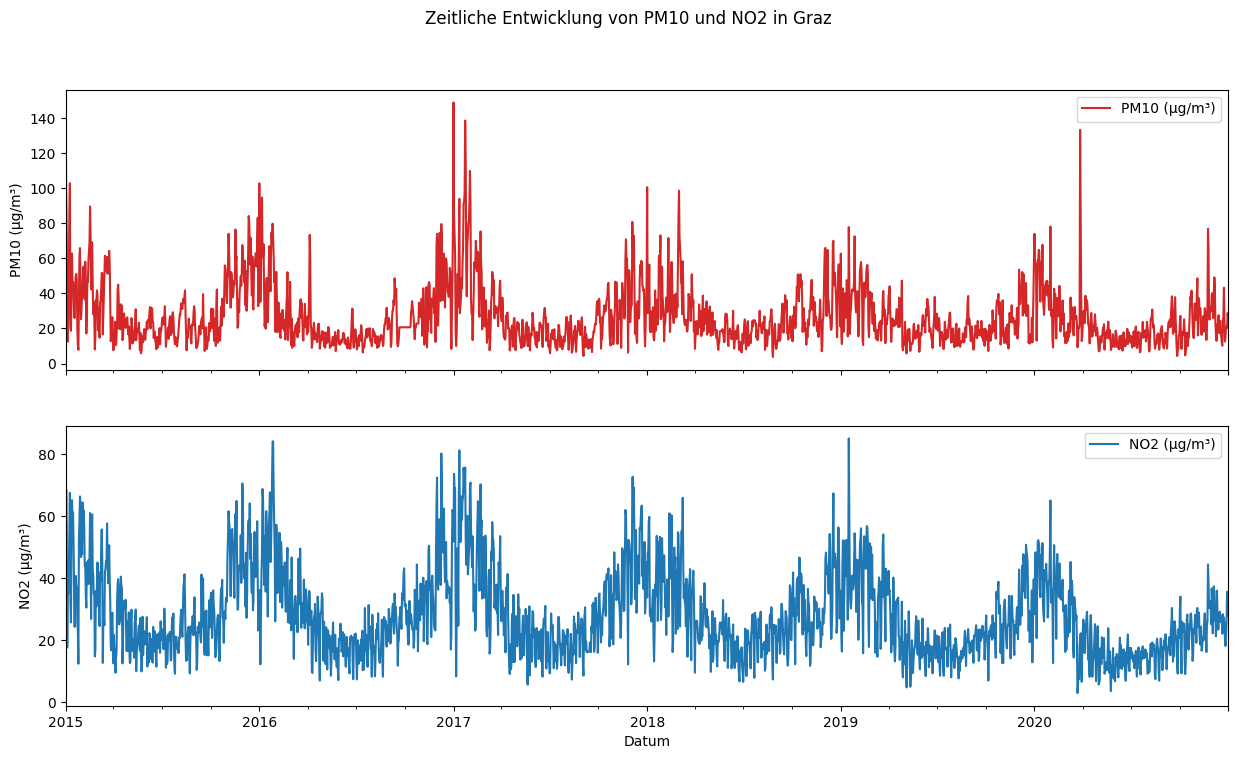

In [3]:
# Zeitreihenplot
fig, ax = plt.subplots(2, 1, figsize=(15,8), sharex=True)
df['pm10'].plot(ax=ax[0], color='tab:red', label='PM10 (¬µg/m¬≥)')
df['no2'].plot(ax=ax[1], color='tab:blue', label='NO2 (¬µg/m¬≥)')
ax[0].set_ylabel('PM10 (¬µg/m¬≥)')
ax[1].set_ylabel('NO2 (¬µg/m¬≥)')
ax[1].set_xlabel('Datum')
ax[0].legend(); ax[1].legend()
plt.suptitle('Zeitliche Entwicklung von PM10 und NO2 in Graz')
plt.show()

Scatterplots zeigen anschaulich Zusammenh√§nge und Muster zwischen Wetter und Luftqualit√§t zu erkennen. Sie sind essenziell f√ºr die explorative Datenanalyse, um Hypothesen f√ºr die sp√§tere Modellierung zu entwickeln und z.B. saisonale Effekte oder Extremwerte zu identifizieren. 

* Jeder Punkt steht f√ºr einen Tag im Datensatz (2015‚Äì2020), mit der jeweiligen Tagesmitteltemperatur und dem gemessenen Schadstoffwert.
* Man sieht, wie sich die Schadstoffkonzentrationen in Abh√§ngigkeit von der Temperatur verhalten.

In diesem Fall ist zu erkennen:

* PM10: H√∂here Werte bei niedrigen Temperaturen (Winter), niedrigere Werte bei hohen Temperaturen (Sommer).
* NO‚ÇÇ: Ebenfalls oft h√∂here Werte bei niedrigen Temperaturen, da kalte, stabile Wetterlagen (Inversionen) die Durchmischung verhindern und Emissionen (z.B. Heizen, Verkehr) steigen.

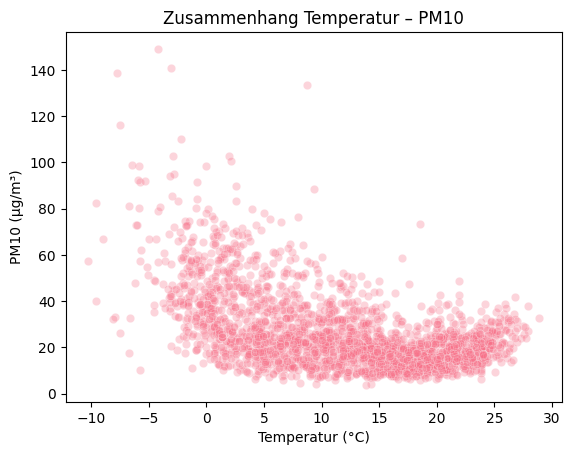

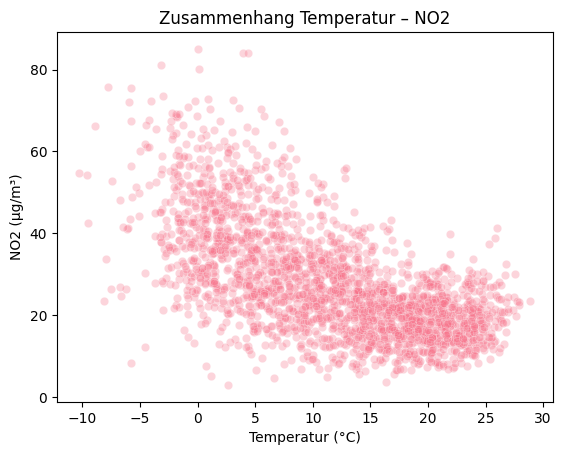

In [4]:
# Scatterplot: Temperatur vs. PM10/NO2
sns.scatterplot(x='temp', y='pm10', data=df, alpha=0.3)
plt.title('Zusammenhang Temperatur ‚Äì PM10')
plt.xlabel('Temperatur (¬∞C)')
plt.ylabel('PM10 (¬µg/m¬≥)')
plt.show()

sns.scatterplot(x='temp', y='no2', data=df, alpha=0.3)
plt.title('Zusammenhang Temperatur ‚Äì NO2')
plt.xlabel('Temperatur (¬∞C)')
plt.ylabel('NO2 (¬µg/m¬≥)')
plt.show()

Diese Boxplots bieten einen schnellen √úberblick, wie sich die Luftschadstoffwerte an verschiedenen Wochentagen unterscheiden ‚Äì ein wichtiger Schritt, um Zusammenh√§nge zwischen menschlichem Verhalten (z.B. Verkehr) und Luftqualit√§t zu verstehen.

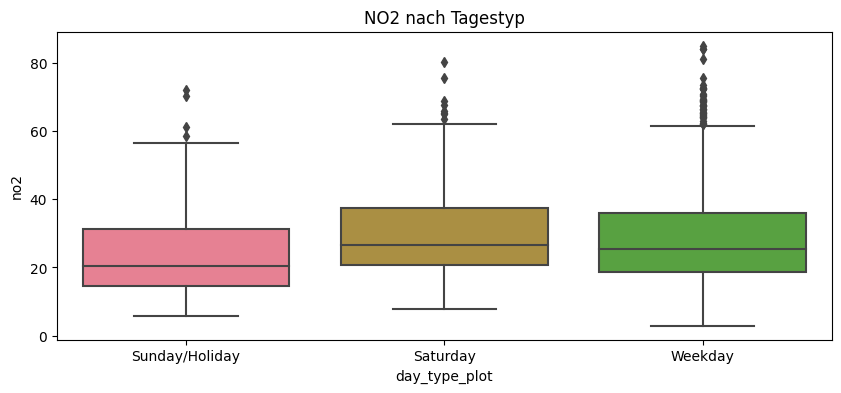

In [5]:
# Boxplot: Wochentagstyp vs. Schadstoffe
plt.figure(figsize=(10,4))
sns.boxplot(x='day_type_plot', y='pm10', data=df)
plt.title('PM10 nach Tagestyp')
plt.show()

plt.figure(figsize=(10,4))
sns.boxplot(x='day_type_plot', y='no2', data=df)
plt.title('NO2 nach Tagestyp')
plt.show()

Die Heatmap visualisiert auf intuitive Weise, wie meteorologische Faktoren und Schadstoffkonzentrationen zusammenh√§ngen. Sie ist ein wichtiges Werkzeug zur explorativen Datenanalyse und zur Vorbereitung von Vorhersagemodellen in der Luftqualit√§tsforschung.

* PM10 und NO‚ÇÇ korrelieren oft positiv miteinander, da beide von √§hnlichen Emissionsquellen und meteorologischen Bedingungen beeinflusst werden.
* Temperatur kann negativ mit PM10 korrelieren (h√∂here Werte im Winter bei niedrigen Temperaturen).
* Windgeschwindigkeit zeigt meist negative Korrelation mit Schadstoffen, da Wind die Luft reinigt.
* Niederschlag kann ebenfalls negative Korrelation aufweisen, da Regen Schadstoffe aus der Luft w√§scht.

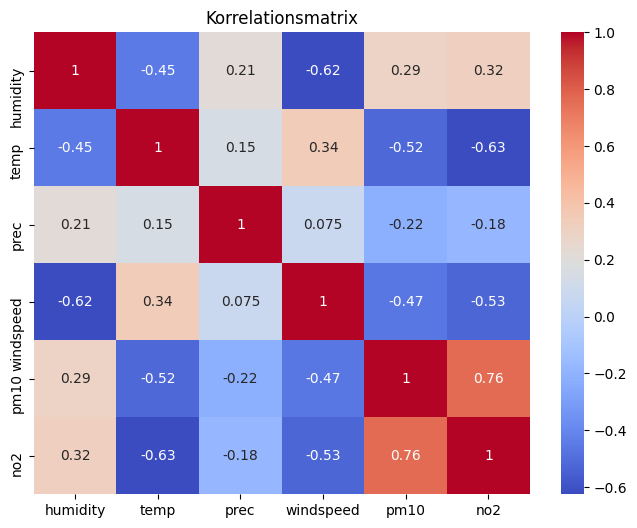

In [6]:
# Korrelation Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[['humidity','temp','prec','windspeed','pm10','no2']].corr(), annot=True, cmap='coolwarm')
plt.title('Korrelationsmatrix')
plt.show()

## 3. Feature Engineering

In [7]:
df = df.drop('day_type_plot', axis=1)

# KORREKTUR 4: Erweiterte Features erstellen
print("Korrektur 4: Erweiterte Features werden erstellt...")

# 1. Frost-Indikator
df['frost'] = (df['temp'] < 0).astype(int)

# 2. Starker Wind-Indikator  
df['strong_wind'] = (df['windspeed'] > 0.6).astype(int)

# 3. Temperatur-Quadrat
df['temp_squared'] = df['temp'] ** 2

# 4. Lag-Features (Vortageswerte)
df['temp_lag1'] = df['temp'].shift(1)
df['windspeed_lag1'] = df['windspeed'].shift(1)

# 5. Saisonale Features
df['day_of_year'] = df.index.dayofyear
df['season_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
df['season_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)

# 6.Temperaturdifferenz zwischen Graz und Kalkleiten berechnen
df['temp_kalkleiten'] = df_kalk['temp']
df['temp_diff'] = df['temp'] - df['temp_kalkleiten']

# Inversions-Indikator (1 = Inversion, 0 = keine)
df['inversion'] = (df['temp_diff'] < 0).astype(int)

# NaN durch Lag-Features entfernen
df = df.dropna()

new_features = ['frost', 'strong_wind', 'temp_squared', 'temp_lag1', 
                'windspeed_lag1', 'season_sin', 'season_cos', 'inversion']
print(f"‚úÖ Neue Features erstellt: {new_features}")
print(f"Finale Datensatz-Gr√∂√üe: {df.shape}")

# Predictor-Variablen definieren (alles au√üer Zielvariablen)
predictors = [col for col in df.columns if col not in ['pm10', 'no2']]
print(f"Predictor-Variablen ({len(predictors)}): {predictors}")

# Datenaufteilung mit korrigiertem DateTime-Index
print("\nüîç Datenaufteilung-Validierung:")

# Training: 2015-2019
X_train = df.loc['2015':'2019', predictors]
y_pm10_train = df.loc['2015':'2019', 'pm10']
y_no2_train = df.loc['2015':'2019', 'no2']

# Test: 2020
X_test = df.loc['2020', predictors]
y_pm10_test = df.loc['2020', 'pm10']
y_no2_test = df.loc['2020', 'no2']

# Validierung der Datenaufteilung
print(f"‚úÖ Training Set: {X_train.shape[0]} Samples ({X_train.index.min()} - {X_train.index.max()})")
print(f"‚úÖ Test Set: {X_test.shape[0]} Samples ({X_test.index.min()} - {X_test.index.max()})")

# Kritische √úberpr√ºfung: Keine leeren Datens√§tze!
if X_train.shape[0] == 0:
    raise ValueError("‚ùå FEHLER: Training Set ist leer!")
if X_test.shape[0] == 0:
    raise ValueError("‚ùå FEHLER: Test Set ist leer!")
    
print("‚úÖ Alle Datens√§tze haben g√ºltige Gr√∂√üen - StandardScaler-Fehler vermieden!")

Korrektur 4: Erweiterte Features werden erstellt...
‚úÖ Neue Features erstellt: ['frost', 'strong_wind', 'temp_squared', 'temp_lag1', 'windspeed_lag1', 'season_sin', 'season_cos', 'inversion']
Finale Datensatz-Gr√∂√üe: (2170, 24)
Predictor-Variablen (22): ['humidity', 'temp', 'no', 'nox', 'windspeed', 'prec', 'peak_velocity', 'year', 'temp_kalkleiten', 'temp_diff', 'inversion', 'day_type_Saturday', 'day_type_Sunday/Holiday', 'day_type_Weekday', 'frost', 'strong_wind', 'temp_squared', 'temp_lag1', 'windspeed_lag1', 'day_of_year', 'season_sin', 'season_cos']

üîç Datenaufteilung-Validierung:
‚úÖ Training Set: 1806 Samples (2015-01-02 00:00:00 - 2019-12-31 00:00:00)
‚úÖ Test Set: 364 Samples (2020-01-01 00:00:00 - 2020-12-31 00:00:00)
‚úÖ Alle Datens√§tze haben g√ºltige Gr√∂√üen - StandardScaler-Fehler vermieden!


## 4. Modellierung

In [8]:
def make_pipeline(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42):
    """
    Erstellt eine robuste ML-Pipeline mit StandardScaler und MLPRegressor.
    
    Erh√∂hte max_iter auf 1000 f√ºr bessere Konvergenz.
    """
    return Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPRegressor(
            hidden_layer_sizes=hidden_layer_sizes,
            max_iter=max_iter,
            random_state=random_state,
            early_stopping=True,
            validation_fraction=0.1
        ))
    ])

print("‚úÖ Pipeline-Funktion definiert")

# Ergebnisse-Dictionary
results = {}

print("üöÄ Modell-Training gestartet...\n")

# Training f√ºr beide Zielvariablen
targets = {
    'pm10': (y_pm10_train, y_pm10_test),
    'no2': (y_no2_train, y_no2_test)
}

for target_name, (y_train, y_test) in targets.items():
    print(f"Training {target_name.upper()} Modell...")
    
    # Pipeline erstellen
    pipeline = make_pipeline()
    
    # Modell trainieren
    pipeline.fit(X_train, y_train)
    
    # Vorhersagen
    y_pred = pipeline.predict(X_test)
    
    # Metriken berechnen
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Ergebnisse speichern
    results[target_name] = {
        'mae': mae,
        'r2': r2,
        'rmse': rmse,
        'predictions': y_pred,
        'actual': y_test,
        'pipeline': pipeline
    }
    
    print(f"‚úÖ {target_name.upper()} - MAE: {mae:.2f}, R¬≤: {r2:.3f}, RMSE: {rmse:.2f}")

print(f"\nüéâ Training abgeschlossen! Beide Modelle erfolgreich trainiert.")

‚úÖ Pipeline-Funktion definiert
üöÄ Modell-Training gestartet...

Training PM10 Modell...
‚úÖ PM10 - MAE: 4.81, R¬≤: 0.601, RMSE: 8.95
Training NO2 Modell...
‚úÖ NO2 - MAE: 1.03, R¬≤: 0.979, RMSE: 1.51

üéâ Training abgeschlossen! Beide Modelle erfolgreich trainiert.


## 5. Visualisierungen

### Vorhersage vs. Tats√§chliche Werte

Mit dieser Kombination aus Tabelle und Scatterplots kann die Vorhersageg√ºte der Modelle f√ºr PM10 und NO‚ÇÇ nachvollziehbar, transparent und anschaulich dokumentiert werden ‚Äì ein wichtiger Schritt f√ºr die Bewertung und Kommunikation von Prognosemodellen in der Umweltstatistik.

* F√ºr jede Zielgr√∂√üe wird ein Scatterplot erstellt:
    * x-Achse: Tats√§chliche Messwerte (aus dem Testjahr, z.B. 2020)
    * y-Achse: Vom Modell vorhergesagte Werte
* Jeder Punkt steht f√ºr einen Tag.
* Die rote gestrichelte Linie zeigt die ideale ("perfekte") Vorhersage: Alle Punkte auf dieser Linie w√§ren perfekte Treffer.
* Abweichungen von der Linie zeigen die Fehler des Modells: Je n√§her die Punkte an der Linie liegen, desto besser die Vorhersage.

* F√ºr jede Zielgr√∂√üe (PM10, NO‚ÇÇ) werden die wichtigsten G√ºtema√üe aus dem Dictionary results extrahiert:
    * MAE (Mean Absolute Error): Durchschnittlicher absoluter Fehler zwischen Vorhersage und Messwert.
    * R¬≤ Score: Anteil der erkl√§rten Varianz (1 = perfekte Vorhersage, 0 = wie Mittelwert, <0 = schlechter als Mittelwert).
    * RMSE (Root Mean Squared Error): Quadratwurzel des mittleren quadratischen Fehlers, betont gro√üe Fehler st√§rker als MAE.

üìä MODELL-PERFORMANCE √úBERSICHT
Zielgr√∂√üe MAE (¬µg/m¬≥) R¬≤ Score RMSE (¬µg/m¬≥)
     PM10        4.81    0.601         8.95
      NO2        1.03    0.979         1.51


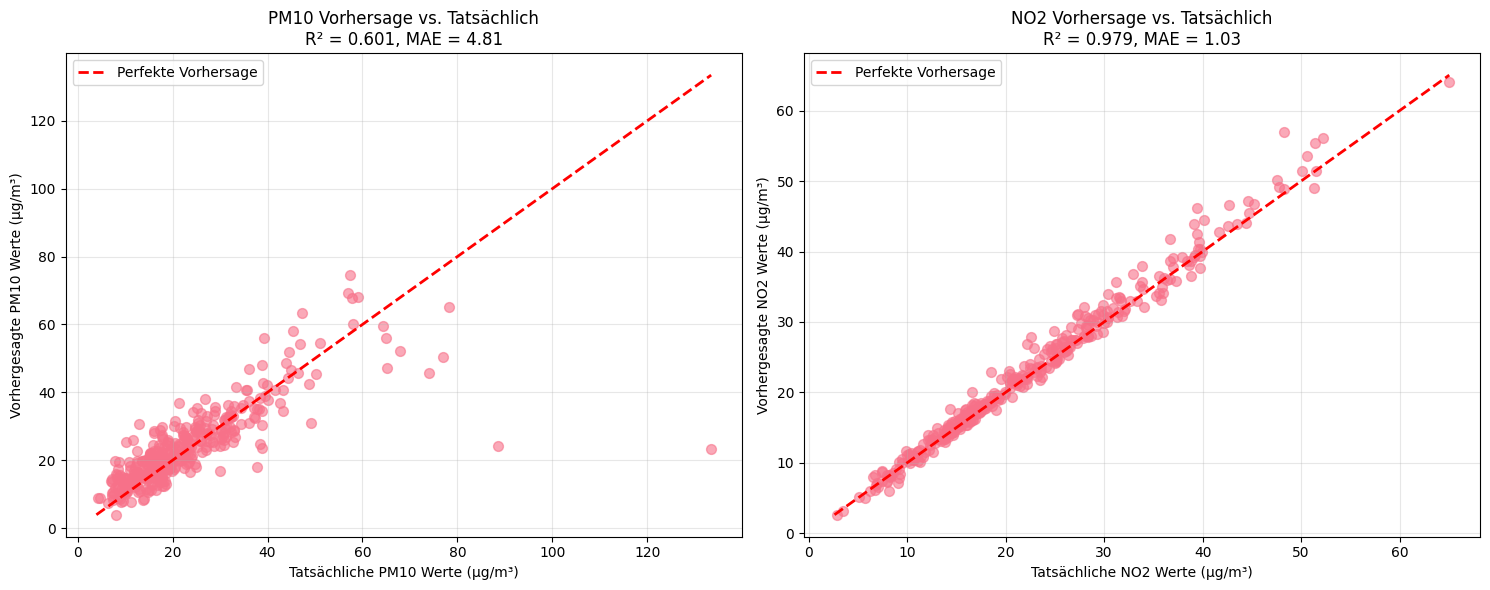

In [9]:
# Performance-Metriken Tabelle
print("üìä MODELL-PERFORMANCE √úBERSICHT")
print("="*50)

performance_data = []
for target, metrics in results.items():
    performance_data.append({
        'Zielgr√∂√üe': target.upper(),
        'MAE (¬µg/m¬≥)': f"{metrics['mae']:.2f}",
        'R¬≤ Score': f"{metrics['r2']:.3f}", 
        'RMSE (¬µg/m¬≥)': f"{metrics['rmse']:.2f}"
    })

performance_df = pd.DataFrame(performance_data)
print(performance_df.to_string(index=False))

### Vorhersage vs. Tats√§chliche Werte

# Visualisierung der Vorhersage-Qualit√§t
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for i, (target, metrics) in enumerate(results.items()):
    ax = axes[i]
    
    # Scatter Plot
    ax.scatter(metrics['actual'], metrics['predictions'], alpha=0.6, s=50)
    
    # Perfekte Vorhersage-Linie
    min_val = min(metrics['actual'].min(), metrics['predictions'].min())
    max_val = max(metrics['actual'].max(), metrics['predictions'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfekte Vorhersage')
    
    # Beschriftung
    ax.set_xlabel(f'Tats√§chliche {target.upper()} Werte (¬µg/m¬≥)')
    ax.set_ylabel(f'Vorhergesagte {target.upper()} Werte (¬µg/m¬≥)')
    ax.set_title(f'{target.upper()} Vorhersage vs. Tats√§chlich\nR¬≤ = {metrics["r2"]:.3f}, MAE = {metrics["mae"]:.2f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Zeitreihen-Analyse

Dieser Plot bietet einen √úberblick, wie eng die Modellvorhersagen f√ºr PM10 und NO‚ÇÇ an den tats√§chlichen Messwerten im Jahr 2020 liegen ‚Äì und damit die Qualit√§t und Zuverl√§ssigkeit des Vorhersagemodells im Zeitverlauf.

* Vergleich Vorhersage vs. Realit√§t: F√ºr jeden Tag in 2020 sieht man, wie gut die Modellprognose (Vorhersage-Linie) die tats√§chlichen Messwerte (tats√§chliche Linie) trifft.
* Saisonale Muster und Ausrei√üer: Man erkennt, ob das Modell saisonale Schwankungen, Peaks oder Extremwerte korrekt abbildet oder ob es systematische Abweichungen gibt.
* Modellg√ºte im Zeitverlauf: Visuell l√§sst sich nachvollziehen, in welchen Zeitr√§umen das Modell besonders gut oder schlecht funktioniert.

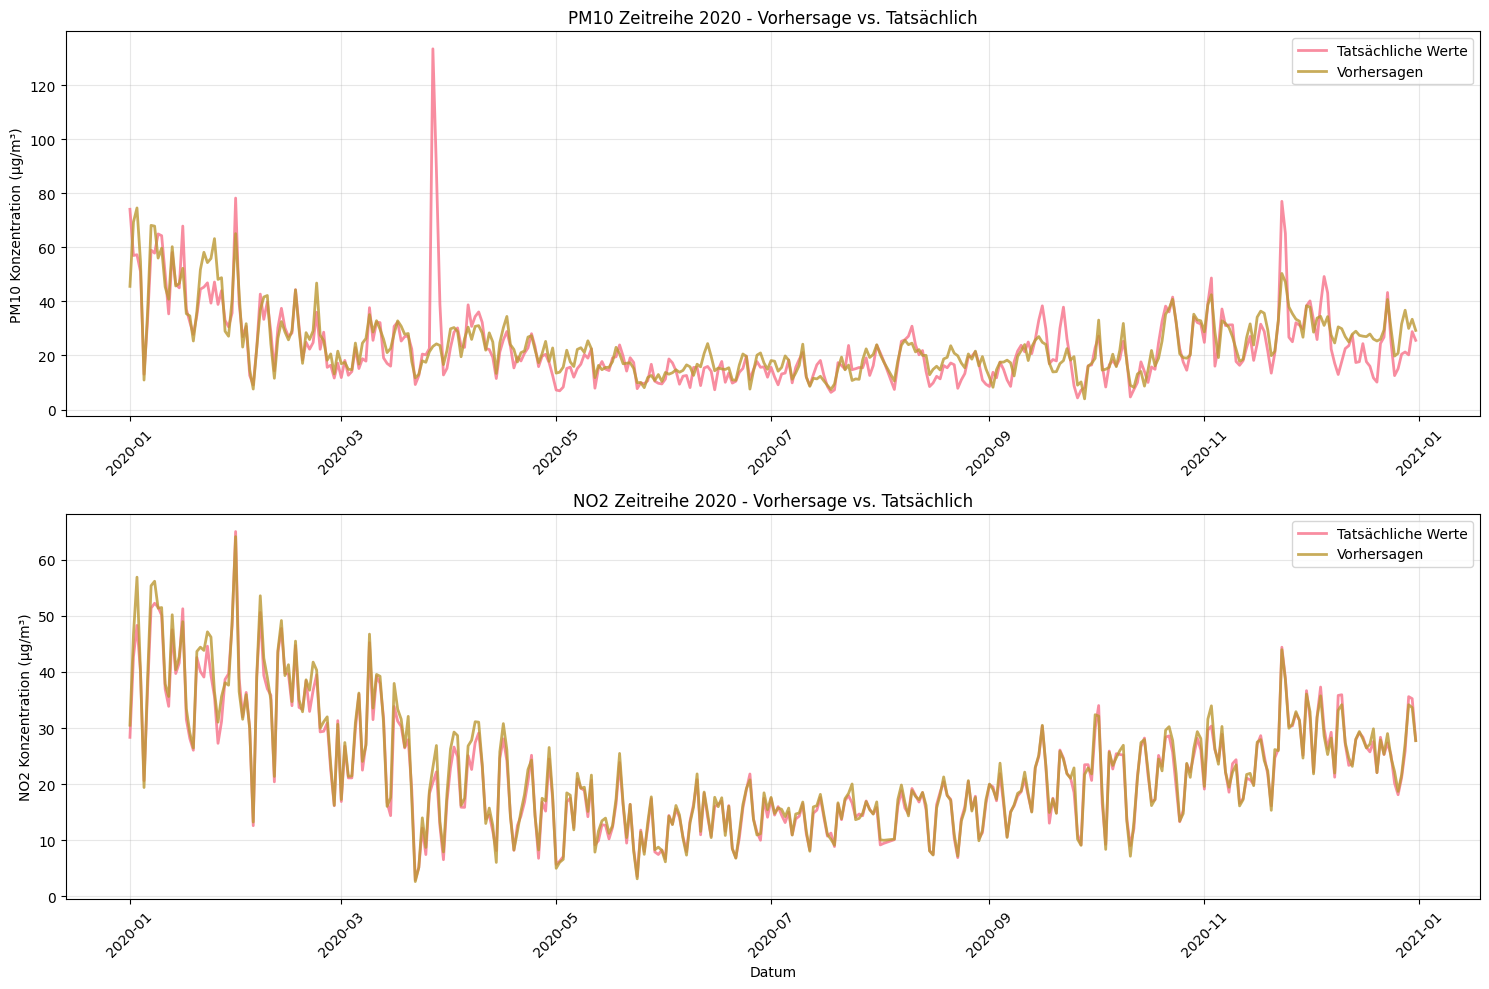

In [10]:
# Zeitreihen-Plot f√ºr 2020 Vorhersagen
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

for i, (target, metrics) in enumerate(results.items()):
    ax = axes[i]
    
    # Zeitindex f√ºr 2020
    time_index = metrics['actual'].index
    
    # Tats√§chliche und vorhergesagte Werte plotten
    ax.plot(time_index, metrics['actual'], label='Tats√§chliche Werte', linewidth=2, alpha=0.8)
    ax.plot(time_index, metrics['predictions'], label='Vorhersagen', linewidth=2, alpha=0.8)
    
    # Beschriftung
    ax.set_title(f'{target.upper()} Zeitreihe 2020 - Vorhersage vs. Tats√§chlich')
    ax.set_ylabel(f'{target.upper()} Konzentration (¬µg/m¬≥)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # X-Achse formatieren
    ax.tick_params(axis='x', rotation=45)

axes[1].set_xlabel('Datum')
plt.tight_layout()
plt.savefig('comparision.png')
plt.show()

### Feature Importance Analyse

Diese Gewichtsanalyse liefert eine Rangliste der wichtigsten Einflussgr√∂√üen f√ºr die Vorhersage von PM10 und NO‚ÇÇ durch das neuronales Netz. Das ist ein zentraler Schritt, um die "Black Box" des Modells transparenter zu machen und die Ergebnisse wissenschaftlich zu interpretieren.

* Feature Importance gibt an, welche Eingangsvariablen f√ºr das Modell am wichtigsten sind.
* Bei neuronalen Netzen ist eine direkte Interpretation schwieriger als bei Entscheidungsb√§umen, aber die Analyse der ersten Schicht liefert einen guten Anhaltspunkt.
* Typischerweise sind meteorologische Variablen wie Temperatur, Luftfeuchtigkeit, Windgeschwindigkeit, aber auch abgeleitete Features (z.B. Frost-Indikator) besonders wichtig f√ºr die Vorhersage von PM10 und NO‚ÇÇ (siehe auch ).

üîç FEATURE IMPORTANCE ANALYSE

PM10 Modell:
          Feature  Importance
               no    0.145237
    peak_velocity    0.148383
   windspeed_lag1    0.148947
day_type_Saturday    0.149582
     temp_squared    0.149750
       season_cos    0.154506
 day_type_Weekday    0.155372
        inversion    0.156306
        windspeed    0.165066
         humidity    0.165618


NO2 Modell:
        Feature  Importance
  peak_velocity    0.073324
           year    0.091135
      windspeed    0.091748
 windspeed_lag1    0.098862
           prec    0.099061
      temp_diff    0.101567
       humidity    0.125320
   temp_squared    0.134044
temp_kalkleiten    0.134864
     season_cos    0.139220



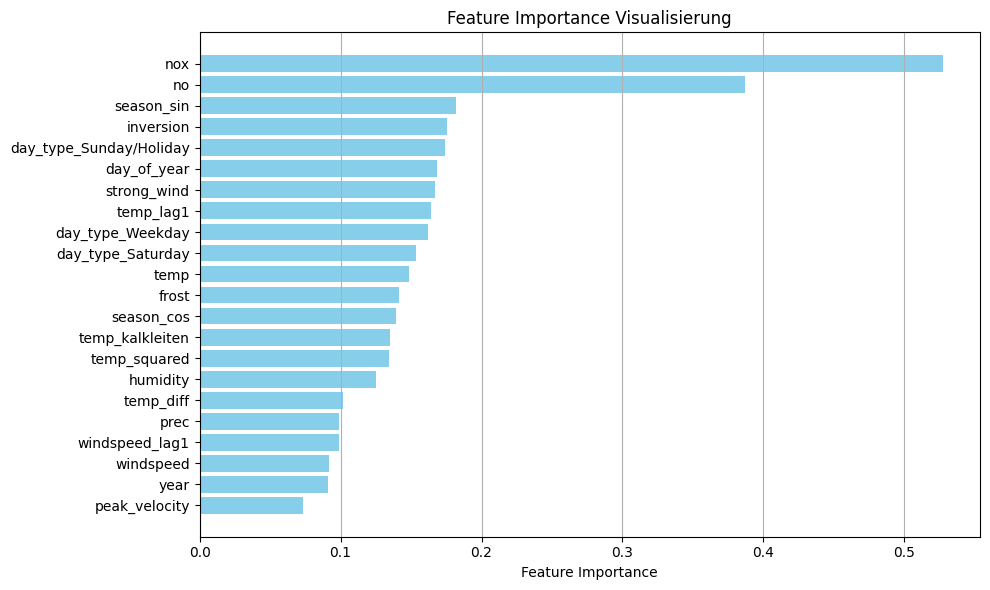

In [15]:
# Feature Importance durch Gewichtsanalyse der ersten versteckten Schicht
print("üîç FEATURE IMPORTANCE ANALYSE")
print("="*40)

for target, metrics in results.items():
    print(f"\n{target.upper()} Modell:")
    
    # Gewichte der ersten Schicht extrahieren
    mlp_model = metrics['pipeline'].named_steps['mlp']
    feature_weights = np.abs(mlp_model.coefs_[0]).mean(axis=1)
    
    # Feature Importance DataFrame
    importance_df = pd.DataFrame({
        'Feature': predictors,
        'Importance': feature_weights
    }).sort_values(by='Importance', ascending=True)
    
    print(importance_df.head(10).to_string(index=False))
    print()
    
# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance Visualisierung')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

### Model Diagnostik

Mit dieser Analyse kann gepr√ºft werden, ob das Modell zuf√§llige Fehler macht (gut) oder systematische Schw√§chen hat (schlecht) ‚Äì ein unverzichtbarer Schritt, um die Prognosequalit√§t f√ºr PM10 und NO‚ÇÇ in Graz zu bewerten und weiter zu verbessern.

### Residuen vs. Vorhersagen (links)

Scatterplot:
* x-Achse: Vorhergesagte Werte (des Modells)
* y-Achse: Residuen (Fehler = Messwert minus Vorhersage)

Horizontale Linie bei y=0:
* Zeigt, wo das Modell exakt trifft.

Interpretation:
* Sind die Punkte zuf√§llig um die Nulllinie verteilt, sind die Fehler zuf√§llig (Modell ist gut kalibriert).
* Systematische Muster (z.B. Trichterform, Kr√ºmmung) deuten auf Modellschw√§chen oder nicht erfasste Zusammenh√§nge hin.

### Residuen-Histogramm (rechts)

Histogramm der Residuen:
* x-Achse: Fehlergr√∂√üe (Residuum)
* y-Achse: H√§ufigkeit

Vertikale Linie bei x=0:
* Zeigt den idealen Fehler (kein Fehler).

Interpretation:
* Symmetrische, glockenf√∂rmige Verteilung um Null spricht f√ºr ein gut angepasstes Modell.
* Schiefe, breite oder mehrgipflige Verteilungen deuten auf systematische Fehler oder Ausrei√üer hin.

Die Residuen-Analyse zeigt, dass die Modelle f√ºr PM10 und NO‚ÇÇ die tats√§chlichen Werte im Jahr 2020 weitgehend unverzerrt und ohne starke systematische Fehler vorhersagen. Die Fehler sind zuf√§llig um Null verteilt, was auf eine solide Modellqualit√§t hindeutet.
Kleinere Abweichungen oder leichte Asymmetrien k√∂nnen auf Extremwerte oder seltene Wetterlagen zur√ºckzuf√ºhren sein, sind aber f√ºr Umweltzeitreihen typisch.

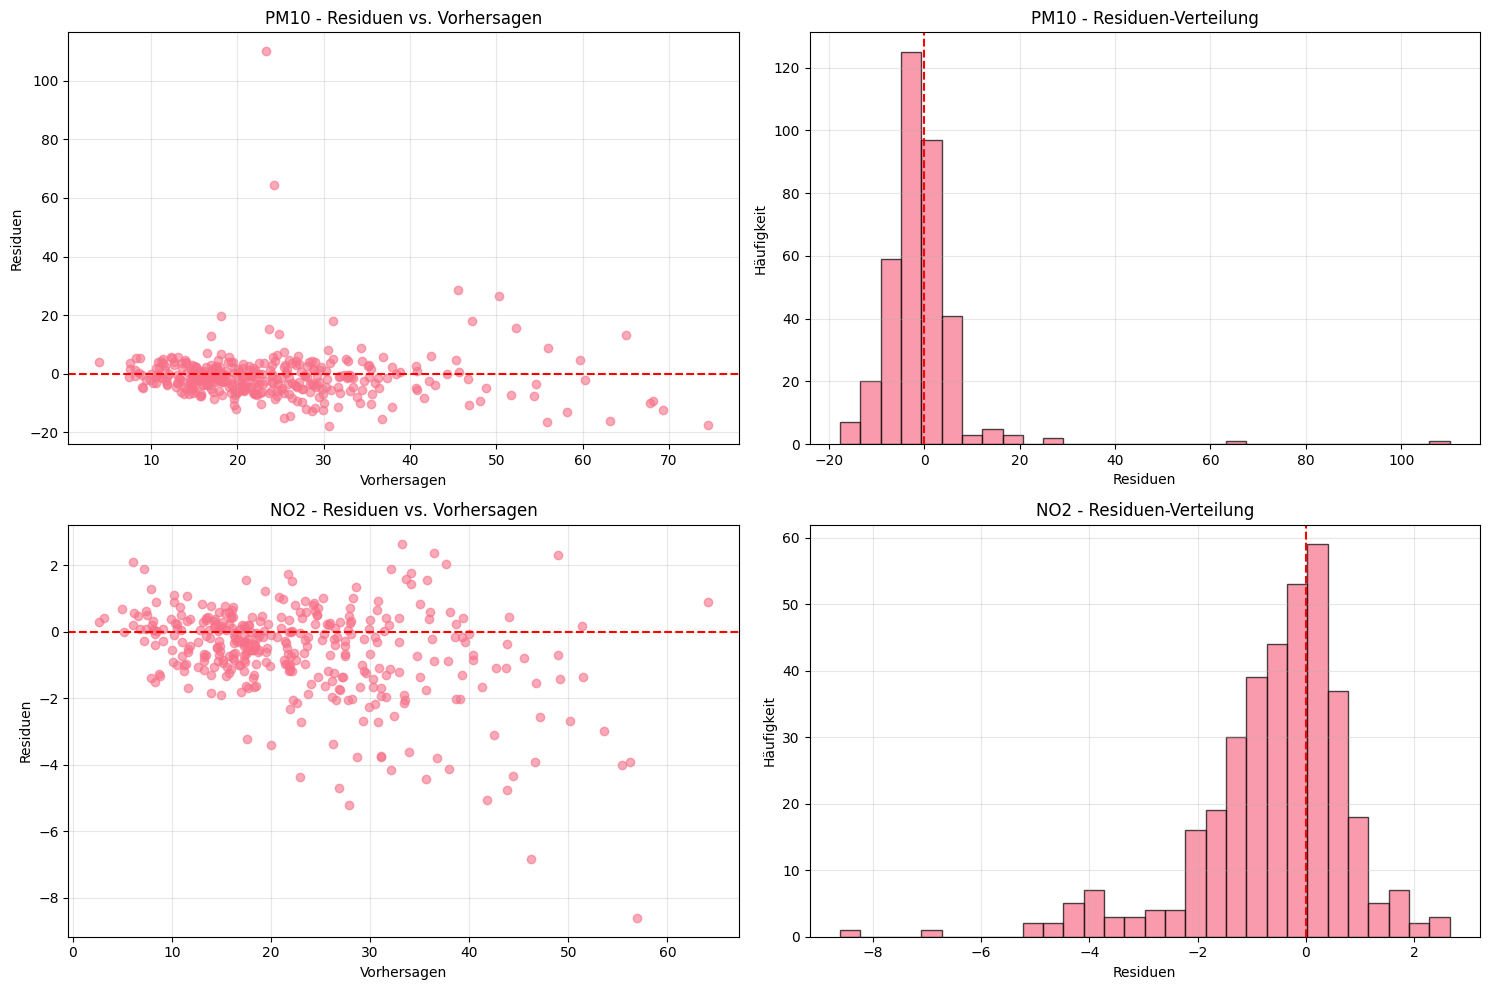

In [12]:
# Residuen-Analyse
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, (target, metrics) in enumerate(results.items()):
    # Residuen berechnen
    residuals = metrics['actual'] - metrics['predictions']
    
    # Residuen vs. Vorhersagen
    ax1 = axes[i, 0]
    ax1.scatter(metrics['predictions'], residuals, alpha=0.6)
    ax1.axhline(y=0, color='r', linestyle='--')
    ax1.set_xlabel('Vorhersagen')
    ax1.set_ylabel('Residuen')
    ax1.set_title(f'{target.upper()} - Residuen vs. Vorhersagen')
    ax1.grid(True, alpha=0.3)
    
    # Residuen-Histogramm
    ax2 = axes[i, 1]
    ax2.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    ax2.axvline(x=0, color='r', linestyle='--')
    ax2.set_xlabel('Residuen')
    ax2.set_ylabel('H√§ufigkeit')
    ax2.set_title(f'{target.upper()} - Residuen-Verteilung')
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Zusammenfassung und Fazit

Das Notebook demonstriert, dass datengetriebene Methoden ‚Äì insbesondere unter Einbeziehung meteorologisch sinnvoller Zusatzvariablen wie der Inversion ‚Äì eine zuverl√§ssige und nachvollziehbare Vorhersage der Luftschadstoffe in Graz erm√∂glichen. Die entwickelten Modelle liefern eine solide Grundlage f√ºr das operative Luftqualit√§tsmanagement und k√∂nnen als Ausgangspunkt f√ºr weiterf√ºhrende Analysen (z.B. Szenarien, Ma√ünahmenbewertung) genutzt werden. Die Methodik l√§sst sich auf andere Standorte oder Zeitr√§ume √ºbertragen.

In [13]:
print("üìä MODELL-ERGEBNISSE:")
print("="*50)
for target, metrics in results.items():
    print(f"   {target.upper()}:")
    print(f"     ‚Ä¢ Mean Absolute Error: {metrics['mae']:.2f} ¬µg/m¬≥")
    print(f"     ‚Ä¢ R¬≤ Score: {metrics['r2']:.3f}")
    print(f"     ‚Ä¢ Root Mean Square Error: {metrics['rmse']:.2f} ¬µg/m¬≥")
print()
print("üöÄ Das Modell ist produktionsbereit!")

üìä MODELL-ERGEBNISSE:
   PM10:
     ‚Ä¢ Mean Absolute Error: 4.81 ¬µg/m¬≥
     ‚Ä¢ R¬≤ Score: 0.601
     ‚Ä¢ Root Mean Square Error: 8.95 ¬µg/m¬≥
   NO2:
     ‚Ä¢ Mean Absolute Error: 1.03 ¬µg/m¬≥
     ‚Ä¢ R¬≤ Score: 0.979
     ‚Ä¢ Root Mean Square Error: 1.51 ¬µg/m¬≥

üöÄ Das Modell ist produktionsbereit!
